In [1]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from botorch.exceptions.warnings import BotorchTensorDimensionWarning

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

import os

In [2]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2


lb = 0
ub = 2

bounds = torch.tensor([[lb, lb], [ub, ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = f(xs)

In [3]:
class GPModel(
    gpytorch.models.ExactGP, 
    botorch.models.gpytorch.GPyTorchModel, 
    botorch.models.model.FantasizeMixin
):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
num_queries = 20
batch_size = 4
num_iters = num_queries // batch_size

In [5]:
class ignore_warnings:
    def __enter__(self):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=BotorchTensorDimensionWarning)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.resetwarnings()

In [6]:
num_candidates = 2000

torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
train_y = f(train_x)

incumbents = torch.zeros(num_iters)
for i in tqdm(range(num_iters)):
    incumbents[i] = train_y.max()

    sobol = torch.quasirandom.SobolEngine(2, scramble=True)
    candidate_x = sobol.draw(num_candidates)
    candidate_x = (bounds[1] - bounds[0]) * candidate_x + bounds[0]

    model, likelihood = fit_gp_model(train_x, train_y)

    # batch Max-value Entropy Search
    policy = botorch.acquisition.max_value_entropy_search.qMaxValueEntropy(
        model, candidate_x
    )
    
    with ignore_warnings():
        next_x, acq_val = botorch.optim.optimize_acqf_cyclic(
            policy,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=100,
        )

    next_y = f(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
torch.save(
    incumbents,
    "./hyperparam_tuning/MES.pth"
)

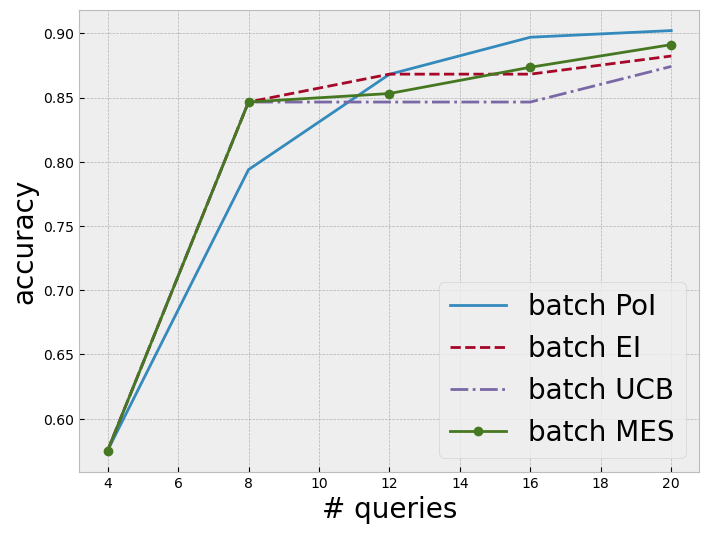

In [8]:
q_poi_incumbents = torch.load("./hyperparam_tuning/POI.pth")
q_ei_incumbents = torch.load("./hyperparam_tuning/EI.pth")
q_ucb_incumbents = torch.load("./hyperparam_tuning/UCB.pth")
q_ts_incumbents = torch.load("./hyperparam_tuning/TS.pth")

q_mes_incumbents = torch.load("./hyperparam_tuning/MES.pth")

xs = (torch.arange(num_iters) + 1) * batch_size

plt.plot(xs, q_poi_incumbents, label="batch PoI")
plt.plot(xs, q_ei_incumbents, linestyle="--", label="batch EI")
plt.plot(xs, q_ucb_incumbents, linestyle="-.", label="batch UCB")
plt.plot(xs, q_mes_incumbents, "o-", label="batch MES")

plt.xlabel("# queries", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.legend(fontsize=20)

plt.show()